In [2]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp

--2019-03-25 12:07:07--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.182
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255268960 (243M) [text/csv]
Saving to: ‘/tmp/train-balanced-sarcasm.csv’

train-balanced-sarc 100%[===================>] 243.44M  11.3MB/s    in 20s     

2019-03-25 12:07:28 (12.3 MB/s) - ‘/tmp/train-balanced-sarcasm.csv’ saved [255268960/255268960]



In [3]:
import sys
import time

from pyspark.sql import SparkSession
packages = [
    'JohnSnowLabs:spark-nlp:2.0.1'
]
spark = SparkSession \
    .builder \
    .appName("ML SQL session") \
    .config('spark.jars.packages', ','.join(packages)) \
    .config('spark.executor.instances','4') \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory","12g") \
    .getOrCreate()

In [4]:
from pyspark.sql import SQLContext

sql = SQLContext(spark)

trainBalancedSarcasmDF = spark.read.option("header", True).option("inferSchema", True).csv("/tmp/train-balanced-sarcasm.csv")
trainBalancedSarcasmDF.printSchema()

# Let's create a temp view (table) for our SQL queries
trainBalancedSarcasmDF.createOrReplaceTempView('data')

sql.sql('SELECT COUNT(*) FROM data').collect()

root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: string (nullable = true)
 |-- ups: string (nullable = true)
 |-- downs: string (nullable = true)
 |-- date: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- parent_comment: string (nullable = true)



[Row(count(1)=1010826)]

In [5]:
df = sql.sql('select label,concat(parent_comment,"\n",comment) as comment from data where comment is not null and parent_comment is not null limit 100000')
print(type(df))
df.printSchema()
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)

+-----+--------------------+
|label|             comment|
+-----+--------------------+
|    0|Yeah, I get that ...|
|    0|The blazers and M...|
|    0|They're favored t...|
|    0|deadass don't kil...|
|    0|Yep can confirm I...|
|    0|do you find arian...|
|    0|What's your weird...|
|    0|Probably Sephirot...|
|    0|What to upgrade? ...|
|    0|Probably count Ka...|
|    0|I bet if that mon...|
|    0|James Shields Wil...|
|    0|There's no time t...|
|    0|Team Specific Thr...|
|    0|Ill give you a hi...|
|    0|Star Wars, easy. ...|
|    0|You're adorable.
...|
|    0|He actually acts ...|
|    0|Clinton struggles...|
|    0|Is that the Older...|
+-----+--------------------+
only showing top 20 rows



In [6]:
%%time

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *


from pyspark.ml import Pipeline


document_assembler = DocumentAssembler() \
    .setInputCol("comment") \
    .setOutputCol("document")
    
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") \
    .setUseAbbreviations(True)
    
tokenizer = Tokenizer() \
  .setInputCols(["sentence"]) \
  .setOutputCol("token")

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer])
nlp_model = nlp_pipeline.fit(df)

processed = nlp_model.transform(df).persist()
processed.count()
processed.show()

train, test = processed.randomSplit(weights=[0.7, 0.3], seed=123)
print(train.count())
print(test.count())

+-----+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|Yeah, I get that ...|[[document, 0, 90...|[[document, 0, 25...|[[token, 0, 3, Ye...|
|    0|The blazers and M...|[[document, 0, 20...|[[document, 0, 13...|[[token, 0, 2, Th...|
|    0|They're favored t...|[[document, 0, 14...|[[document, 0, 22...|[[token, 0, 3, Th...|
|    0|deadass don't kil...|[[document, 0, 90...|[[document, 0, 90...|[[token, 0, 6, de...|
|    0|Yep can confirm I...|[[document, 0, 11...|[[document, 0, 48...|[[token, 0, 2, Ye...|
|    0|do you find arian...|[[document, 0, 14...|[[document, 0, 14...|[[token, 0, 1, do...|
|    0|What's your weird...|[[document, 0, 98...|[[document, 0, 52...|[[token, 0, 3, Wh...|
|    0|Probably Sephirot...|[[document, 0, 14...|[[document, 0, 18...|[[token, 0

In [7]:
%%time

glove =  WordEmbeddingsModel.pretrained()
train_featurized =glove.transform(train)
train_featurized.count()
train_featurized.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|          embeddings|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|              !
Goes|[[document, 0, 5,...|[[document, 0, 5,...|[[token, 0, 0, !,...|[[word_embeddings...|
|    0|!completed
!compl...|[[document, 0, 20...|[[document, 0, 20...|[[token, 0, 0, !,...|[[word_embeddings...|
|    0|""" ""Very Right ...|[[document, 0, 10...|[[document, 0, 10...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|""" Perhaps you n...|[[document, 0, 61...|[[document, 0, 46...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|""" This covering...|[[document, 0, 33...|[[document, 0, 84...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""*Kirk
I am sin...|[[document, 0, 44...|[[document, 0, 44...|[[token, 0, 3, ""...|[[wor

In [8]:
%%time

test_featurized =glove.transform(test)

CPU times: user 6.38 ms, sys: 3.04 ms, total: 9.42 ms
Wall time: 115 ms


In [9]:
%%time

x_train_df = train_featurized.select(['embeddings']).toPandas()
y_train_df = train_featurized.select(['label']).toPandas()
x_test_df = test_featurized.select(['embeddings']).toPandas()
y_test_df = test_featurized.select(['label']).toPandas()

CPU times: user 2min 22s, sys: 3min 25s, total: 5min 48s
Wall time: 12min 53s


In [10]:
print('Train Labels:\n',y_train_df.label.value_counts())
print('Test Labels:\n',y_test_df.label.value_counts())

Train Labels:
 0    40466
1    29670
Name: label, dtype: int64
Test Labels:
 0    17224
1    12640
Name: label, dtype: int64


In [11]:
%%time

import numpy as np
def get_features(row):
    result = []
    for tk in row:
      result.append(tk['embeddings'])
    return np.array(result)

x_train_df['features'] = x_train_df['embeddings'].apply(lambda z: get_features(z))
# x_train
x_test_df['features'] = x_test_df['embeddings'].apply(lambda z: get_features(z))
# x_test.drop(['embeddings'],axis=1,inplace=True)

x_train = x_train_df['features'].values
x_test = x_test_df['features'].values
y_train = y_train_df['label'].values
y_test = y_test_df['label'].values

CPU times: user 42.5 s, sys: 31.2 s, total: 1min 13s
Wall time: 2min 43s


In [12]:
%%time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

# set parameters for our model:
maxlen = 100 #max 50 words per article
batch_size = 32 #size of the batch 
filters = 50 #dimension of filters for the convolutional layer
kernel_size = 3 #size of the kernel used in the convolutional layer
hidden_dims = 250 #dimension of the hidden layer
epochs = 5 #number of training epochs

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

CPU times: user 5.1 s, sys: 10.1 s, total: 15.2 s
Wall time: 16.4 s


In [13]:
%%time

print('Build model...')
model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

from keras import backend as K


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mae'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Build model...
Train on 70136 samples, validate on 29864 samples
Epoch 1/5
70136/70136 [==============================] - 83s 1ms/step - loss: 0.6554 - acc: 0.6178 - mean_absolute_error: 0.4620 - val_loss: 0.6464 - val_acc: 0.6298 - val_mean_absolute_error: 0.4492
Epoch 2/5
70136/70136 [==============================] - 79s 1ms/step - loss: 0.6289 - acc: 0.6495 - mean_absolute_error: 0.4384 - val_loss: 0.6391 - val_acc: 0.6387 - val_mean_absolute_error: 0.4506
Epoch 3/5
70136/70136 [==============================] - 78s 1ms/step - loss: 0.6095 - acc: 0.6687 - mean_absolute_error: 0.4216 - val_loss: 0.6379 - val_acc: 0.6429 - val_mean_absolute_error: 0.4368
Epoch 4/5
70136/70136 [==============================] - 80s 1ms/step - loss: 0.5913 - acc: 0.6862 - mean_absolute_error: 0.4055 - val_loss: 0.6522 - val_acc: 0.6226 - val_mean_absolute_error: 0.4489
Epoch 5/5
70136/70136 [==============================] - 83s 1ms/step - loss: 0.5737 - acc: 0.7012 - mean_absolute_error: 0.3908 - val_

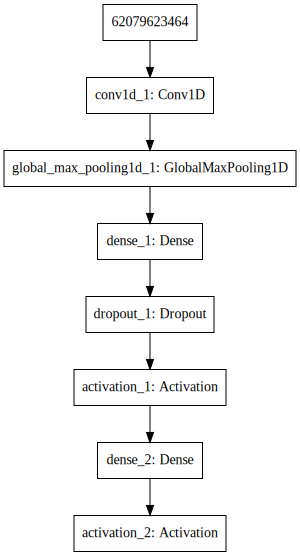

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
spark.stop()